In [1]:
# 加载训练数据集
import numpy as np

import cv2
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        self.base = base # 数据集根目录
        self.name = name # 目录名
        self.file = file # 图像文件名

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 

# 获取根目录
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # 检查文件名后缀，仅支持 jpg 和 jpeg 两种文件格式
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

#转化为image
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV 默认使用 BGR 通道加载图像，转换为 RGB 图像
    return img[...,::-1]


metadata = load_metadata('images')
img = load_image(metadata[0].image_path())

print(img.dtype)
print(metadata)

uint8
[images/Jacques_Chirac/Jacques_Chirac_0020.jpg
 images/Jacques_Chirac/Jacques_Chirac_0008.jpg
 images/Jacques_Chirac/Jacques_Chirac_0009.jpg
 images/Jacques_Chirac/Jacques_Chirac_0019.jpg
 images/Jacques_Chirac/Jacques_Chirac_0001.jpg
 images/Jacques_Chirac/Jacques_Chirac_0002.jpg
 images/Jacques_Chirac/Jacques_Chirac_0003.jpg
 images/Jacques_Chirac/Jacques_Chirac_0007.jpg
 images/Jacques_Chirac/Jacques_Chirac_0004.jpg
 images/Jacques_Chirac/Jacques_Chirac_0005.jpg
 images/Gerhard_Schroeder/Gerhard_Schroeder_0009.jpg
 images/Gerhard_Schroeder/Gerhard_Schroeder_0008.jpg
 images/Gerhard_Schroeder/Gerhard_Schroeder_0001.jpg
 images/Gerhard_Schroeder/Gerhard_Schroeder_0003.jpg
 images/Gerhard_Schroeder/Gerhard_Schroeder_0002.jpg
 images/Gerhard_Schroeder/Gerhard_Schroeder_0006.jpg
 images/Gerhard_Schroeder/Gerhard_Schroeder_0007.jpg
 images/Gerhard_Schroeder/Gerhard_Schroeder_0005.jpg
 images/Gerhard_Schroeder/Gerhard_Schroeder_0004.jpg
 images/Gerhard_Schroeder/Gerhard_Schroeder_001

In [2]:
print(img.dtype)

uint8


uint8


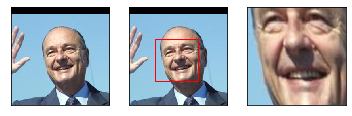

In [3]:
#人脸检测、对齐、提取
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

# 初始化 OpenFace 人脸对齐工具，使用 Dlib 提供的 68 个关键点
alignment = AlignDlib('face_detection/landmarks.dat')

# 加载一张训练图像
img = load_image(metadata[0].image_path())

# 检测人脸并返回边框
bb = alignment.getLargestFaceBoundingBox(img)

# 使用指定的人脸关键点转换图像并截取 96x96 的人脸图像
aligned_img = alignment.align(96, img, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

# 绘制原图
plt.subplot(131)
plt.imshow(img)
plt.xticks([])
plt.yticks([])

# 绘制带人脸边框的原图
plt.subplot(132)
plt.imshow(img)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))
plt.xticks([])
plt.yticks([])

# 绘制对齐后截取的 96x96 人脸图像
plt.subplot(133)
plt.imshow(aligned_img)
plt.xticks([])
plt.yticks([])
print(img.dtype)

In [4]:
print(img.dtype)

uint8


In [5]:
from model import create_model

nn4_small2 = create_model()

from keras.models import Model
from keras.layers import Input, Layer

# 输入 anchor, positive and negative 96x96 RGB图像
in_a = Input(shape=(96, 96, 3))
in_p = Input(shape=(96, 96, 3))
in_n = Input(shape=(96, 96, 3))

# 输出对应的人脸特征向量
emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)



Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [6]:
from keras import backend as K

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

In [7]:
print(img.dtype)

uint8


In [8]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('models/nn4.small2.v1.h5')

In [9]:
print(img.dtype)

uint8


In [10]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
embedded = np.zeros((metadata.shape[0], 128))

In [11]:
print(img.dtype)

uint8


In [12]:
print(img.dtype)
for i, m in enumerate(metadata):
    img = load_image(m.image_path())
    #print(img.dtype)
    # 使用指定的人脸关键点转换图像并截取 96x96 的人脸图像
    img = alignment.align(96, img, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
    #img = align_image(img)
    # 数据规范化
    img = (img / 255.).astype(np.float32)
    # 人脸特征向量
    embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]

uint8



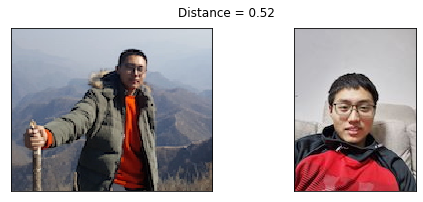

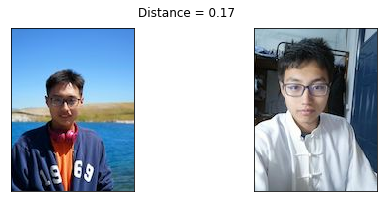

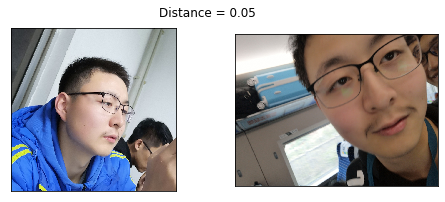

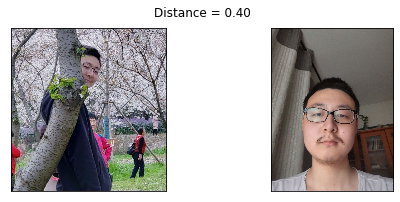

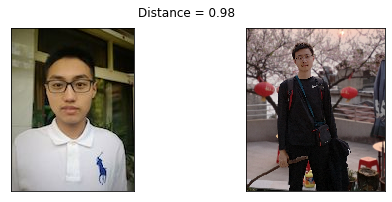

In [27]:
# Squared L2 Distance
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()))
    plt.xticks([])
    plt.yticks([])


show_pair(63, 67)
show_pair(61, 66)
show_pair(34, 35)
show_pair(30, 37) 
show_pair(65, 39)

In [14]:
#import os
#os.environ["PATH"] += os.pathsep + '/Users/cuixingqi/'
#plot_model(nn4_small2, to_file='nn4_small2_model.png', show_shapes=True)

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score


targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.9, SVM accuracy = 0.9


([], <a list of 0 Text yticklabel objects>)

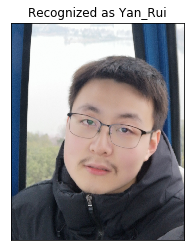

In [16]:
import warnings
warnings.filterwarnings('ignore')

example_idx = 66
example_image = load_image(metadata[example_idx].image_path())
example_prediction = svc.predict([embedded[example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Recognized as {example_identity}');
plt.xticks([])
plt.yticks([])

example_idx = 38
example_image = load_image(metadata[example_idx].image_path())
example_prediction = svc.predict([embedded[example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Recognized as {example_identity}');
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

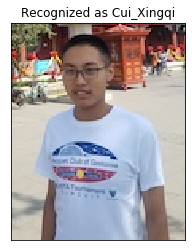

In [23]:
example_idx = 68
example_image = load_image(metadata[example_idx].image_path())
example_prediction = svc.predict([embedded[example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Recognized as {example_identity}');
plt.xticks([])
plt.yticks([])

0.6299999999999997


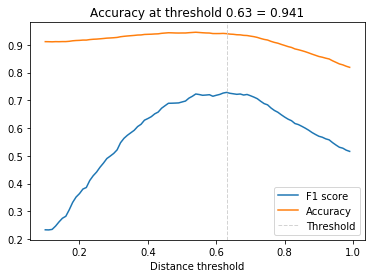

In [26]:
from sklearn.metrics import f1_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(embedded[i], embedded[j])) #人脸特征向量
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.1, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)

opt_tau = thresholds[opt_idx] # 最大F1值对应的 threshold

opt_acc = accuracy_score(identical, distances < opt_tau) # 最大F1值对应的准确率 

# 绘制F1值和准确率与 threshold 间关系
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();
print(opt_tau)

0.6299999999999997


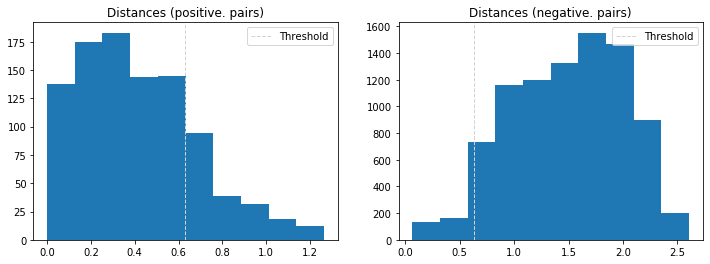

In [22]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (positive. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (negative. pairs)')

plt.legend();
print(opt_tau)

([], <a list of 0 Text yticklabel objects>)

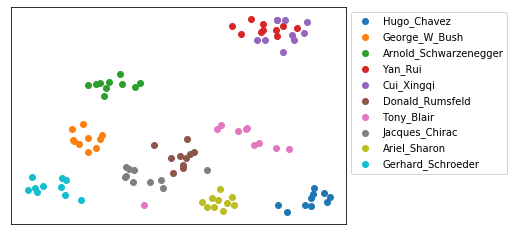

In [19]:
# 降维人脸向量
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));
plt.xticks([])
plt.yticks([])